In [14]:
import threading, random, functools
from collections import deque
import matplotlib.pyplot as plt

random.seed(0.1)
WE_pass_init = [False, False, True, False]
MAX_ITER = 5000

# ===== EVENT SYSTEM ====

@functools.total_ordering
class Event:
    def __init__(self, time, f):
        self.time = time
        self.f = f

    def __eq__(self, other):
        return self.time == other.time

    def __lt__(self, other):
        return self.time < other.time

class Scheduler(threading.Thread):
    def __init__(self): 
        super().__init__()
        self.time = 0
        self.event_queue = queue.PriorityQueue()
        
    def schedule(self, event, time):
        self.event_queue.put(Event(self.time + time, event))
    
    def run(self):
        while True:
            if self.time > MAX_ITER:
                return
            next_event = self.event_queue.get()
            self.time = next_event.time
            next_event.f()
            
scheduler = Scheduler()


# ===== ROAD MODEL =====

class Lane:
    def __init__(self, capacity=100, intersection_name=''):
        self.capacity = capacity
        self.intersection_name = intersection_name
        self.queue = deque()
        self.cv = threading.Condition()
        self.timestamps = []
        self.history = []
        self.action_history = []
    
    def enqueue(self, vehicle):
        with self.cv:
            while not len(self.queue) < self.capacity:
                self.cv.wait()
            self.queue.append(vehicle)
            self.timestamps.append(scheduler.time)
            self.history.append(len(self.queue))
            self.action_history.append('en')
        scheduler.schedule(lambda: vehicle.wait_on_light(), 15)
            
    def insert(self, vehicle):
        with self.cv:
            while not len(self.queue) < self.capacity:
                self.cv.wait()
            self.queue.insert(random.randint(0,len(self.queue)), vehicle)
            self.timestamps.append(scheduler.time)
            self.history.append(len(self.queue))
            self.action_history.append('in')
    
    def remove(self, vehicle):
        with self.cv:
            self.queue.remove(vehicle)
            self.timestamps.append(scheduler.time)
            self.history.append(len(self.queue))
            self.action_history.append('rm')
            self.cv.notify() 
        
lane_13th_street = Lane(10, intersection_name='Peachtree & 13th')

# ===== ROAD PROCESS ======

class Intersection(threading.Thread):
    def __init__(self, name, lane_cap=[], first=False, last=False, WE_pass=False):
        super().__init__()
        self.name = name
        self.first = first
        self.last = last
        if not first:
            self.lanes = list(map(lambda c: Lane(c, intersection_name=name), lane_cap))
        self.incoming = [Lane(50, intersection_name=name), Lane(50, intersection_name=name)] # [W-E, S]
        self.WE_pass = WE_pass
        
    def run(self):
        scheduler.schedule(lambda: self.change_light(), 0)
    
    
    # TODO: notify
    
    def change_light(self):                
        self.WE_pass = not self.WE_pass
        # Traffic from n-th St can enter (except 14th)
        if self.WE_pass and not self.last:
            for i in range(min(10, len(self.incoming[0].queue))):
                vehicle = self.incoming[0].queue[i]
                with vehicle.cv:
                    vehicle.cv.notify()
        else:
            # Traffic from south of 10th St.
            if self.first:
                for i in range(min(10, len(self.incoming[1].queue))):
                    vehicle = self.incoming[1].queue[i]
                    with vehicle.cv:
                        vehicle.cv.notify()
            # Traffic along Peachtree St.
            else:
                for i, lane in enumerate(self.lanes):
                    for j in range(min(10, len(lane.queue))):
                        vehicle = lane.queue[j]
                        if vehicle.waiting or not vehicle.ready:
                            continue
                        with vehicle.cv:
                            vehicle.cv.notify() 
        if scheduler.time < MAX_ITER:
            scheduler.schedule(lambda: self.change_light(), 120)

peachtree_and_10th = Intersection("Peachtree and 10th", first=True, WE_pass=WE_pass_init[0])
peachtree_and_11th = Intersection("Peachtree and 11th", [30, 50,50], WE_pass=WE_pass_init[1])
peachtree_and_12th = Intersection("Peachtree and 12th", [30, 50, 50], WE_pass=WE_pass_init[2])
peachtree_and_14th = Intersection("Peachtree and 14th", [30, 80, 80], WE_pass=WE_pass_init[3])


# ===== VEHICLE PROCESS ======

total_time = []

class Vehicle(threading.Thread):
    vehicle_id = 0
    
    def __init__(self, entry, init_lane=None): 
        super().__init__()
        # 0 - 10th St, 1 - 11th St, etc.
        self.entry = entry
        self.cur_lane = init_lane
        self.direction = 0
        self.waiting = False
        self.cv = threading.Condition()
        self.id = Vehicle.vehicle_id
        Vehicle.vehicle_id += 1
        
    
    def run(self):
        start_time = scheduler.time
        with self.cv:
            # Peachtree & 11th
            if self.entry < 1:
                self.cv.wait()
                scheduler.schedule(lambda: self.enter(peachtree_and_11th), 2)
            # Peachtree & 12th
            if self.entry < 2:
                self.cv.wait()
                if self.direction:
                    self.exit()
                    return
                scheduler.schedule(lambda: self.enter(peachtree_and_12th), 2)
            # Peachtree & 14th
            if self.entry == 3:
                scheduler.schedule(lambda: self.enter(peachtree_and_14th, random_pos=True), 2)
            else:
                self.cv.wait()
                if self.direction:
                    self.exit()
                    return
                scheduler.schedule(lambda: self.enter(peachtree_and_14th), 2)
            self.cv.wait()
            self.exit()
        end_time = scheduler.time
        total_time.append(end_time - start_time)
    
    def enter(self, intersection, random_pos=False):
        # 0 - straight, -1 - left, 1 - right
        self.direction = random.choice([-1, 0, 1])
        
        if self.direction == -1:
            next_lane = intersection.lanes[1]
            left_lane = intersection.lanes[0]
            self.waiting = True
        else:
            next_lane = intersection.lanes[random.choice([1, 2])]
            
        self.ready = False                    
        with next_lane.cv:
            while not len(next_lane.queue) < next_lane.capacity:
                next_lane.cv.wait()
            if self.cur_lane != None:
                self.cur_lane.remove(self)
            self.cur_lane = next_lane
            if random_pos:
                self.cur_lane.insert(self)
            else:
                self.cur_lane.enqueue(self)
            # Enter left-turning lane after 5 seconds
            if self.waiting:
                scheduler.schedule(lambda: self.change_lane(left_lane), 5) 
        
    def change_lane(self, left_lane):
        with left_lane.cv:
            while not len(left_lane.queue) < left_lane.capacity:
                left_lane.cv.wait()
            self.cur_lane.remove(self)
            self.cur_lane = left_lane
            self.cur_lane.enqueue(self)
            self.waiting = False

    def wait_on_light(self):
        self.ready = True
    
    def exit(self):
        self.cur_lane.remove(self)

# ===== INPUT =====

class TrafficGenerator(threading.Thread):
            
    def spawn_vehicle_on(self, lane, entry):
        with lane.cv:
            if len(lane.queue) < lane.capacity:
                vehicle = Vehicle(entry, init_lane=lane)
                lane.enqueue(vehicle)
                vehicle.start()
        
        # Invoke recursively
        if scheduler.time < MAX_ITER:
            time_before_next = random.randrange(300, 400) if entry == 3 else random.randrange(5, 60)
            scheduler.schedule(lambda: self.spawn_vehicle_on(lane, entry), time_before_next)
        
    def spawn_vehicle(self, intersection, entry):
        if intersection.first:
            self.spawn_vehicle_on(intersection.incoming[random.choice([0, 1])], entry)
        else:
            self.spawn_vehicle_on(intersection.incoming[0], entry)
            
    def run(self):
        for i, intersection in enumerate([peachtree_and_10th, peachtree_and_11th, peachtree_and_12th]):
            self.spawn_vehicle(intersection, i)
        self.spawn_vehicle_on(lane_13th_street, 3)
            
traffic = TrafficGenerator()

In [15]:
# Starts simulation
traffic.start()
scheduler.schedule(lambda: peachtree_and_10th.start(), 20)
scheduler.schedule(lambda: peachtree_and_11th.start(), 40)
scheduler.schedule(lambda: peachtree_and_12th.start(), 60)
scheduler.schedule(lambda: peachtree_and_14th.start(), 80)
scheduler.start()

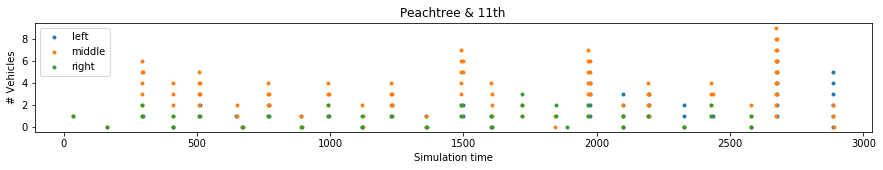

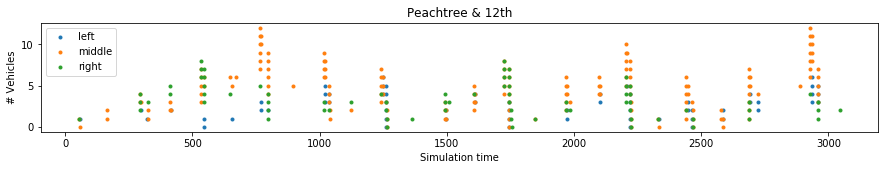

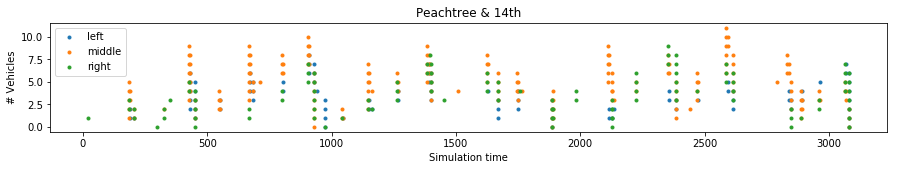

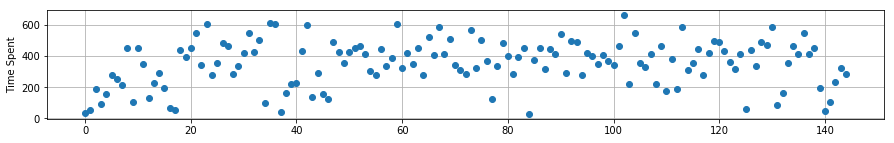

In [16]:
lanes = ['left', 'middle', 'right']

plt.figure(figsize=(15,2))
plt.title('Peachtree & 11th')
for i in range(3):
    plt.plot(peachtree_and_11th.lanes[i].timestamps, peachtree_and_11th.lanes[i].history, '.', label=lanes[i])
plt.ylabel('# Vehicles')
plt.xlabel('Simulation time')
plt.legend()

plt.figure(figsize=(15,2))
plt.title('Peachtree & 12th')
for i in range(3):
    plt.plot(peachtree_and_12th.lanes[i].timestamps, peachtree_and_12th.lanes[i].history, '.', label=lanes[i])
plt.ylabel('# Vehicles')
plt.xlabel('Simulation time')
plt.legend()

plt.figure(figsize=(15,2))
plt.title('Peachtree & 14th')
for i in range(3):
    plt.plot(peachtree_and_14th.lanes[i].timestamps, peachtree_and_14th.lanes[i].history, '.', label=lanes[i])
plt.ylabel('# Vehicles')
plt.xlabel('Simulation time')
plt.legend()

plt.figure(figsize=(15,2))
plt.ylabel('Time Spent')
plt.plot(total_time, 'o')
plt.grid()